In [1]:
import time
import datetime
import pandas as pd

ticker = "TSLA"

period1 = int(time.mktime(datetime.datetime(2019, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2023, 10, 31, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

df = pd.read_csv(query_string)
df.head()

#df.to_csv('TSLA.csv')   #Now we have the Tesla stock price which can be used for training other models as well.

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
1,2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2,2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
3,2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
4,2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


In [2]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


In [3]:
import numpy as np

data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
print(dataset)
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

[[ 20.674667]
 [ 20.024   ]
 [ 21.179333]
 ...
 [205.759995]
 [207.300003]
 [197.360001]]


973

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1216 entries, 2019-01-02 to 2023-10-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1216 non-null   float64
 1   High       1216 non-null   float64
 2   Low        1216 non-null   float64
 3   Close      1216 non-null   float64
 4   Adj Close  1216 non-null   float64
 5   Volume     1216 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.5+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1.216000e+03
mean,168.665167,172.511397,164.512223,168.598015,168.598015,1.345194e+08
std,109.572637,111.952138,106.880483,109.412862,109.412862,8.681057e+07
min,12.073333,12.445333,11.799333,11.931333,11.931333,2.940180e+07
25%,46.882333,49.423501,45.738000,47.255000,47.255000,7.935510e+07
50%,195.730004,199.296669,190.381668,194.889999,194.889999,1.087738e+08
75%,251.680004,257.485008,246.355839,252.077500,252.077500,1.609662e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


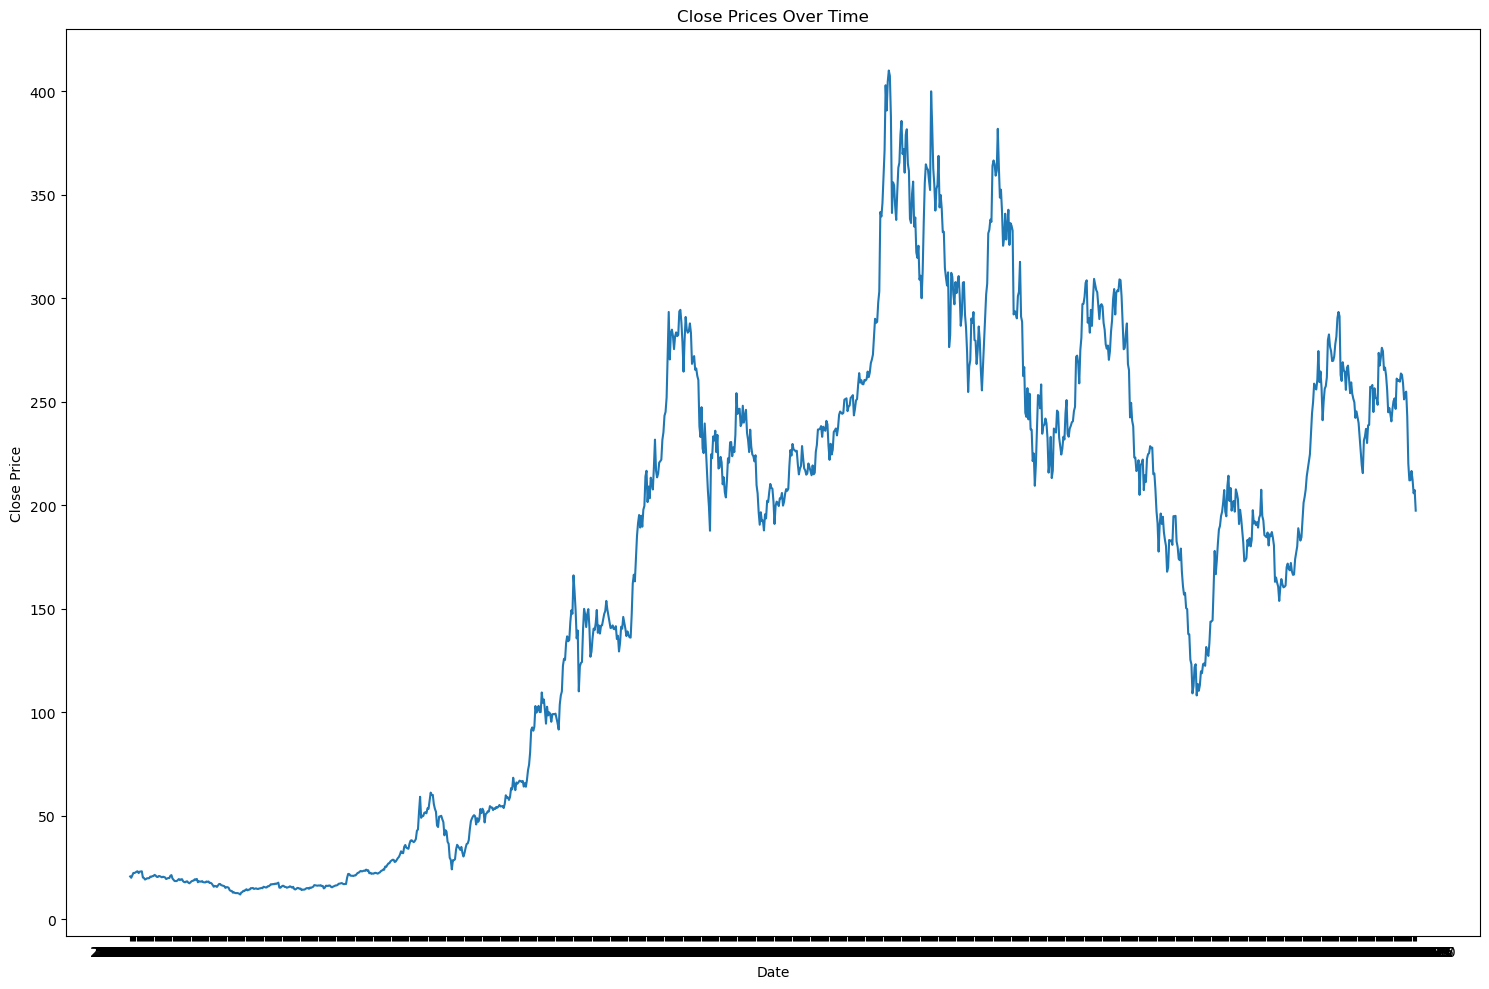

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Close'])
plt.title('Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.tight_layout()

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02196604],
       [0.02033136],
       [0.02323392],
       ...,
       [0.48695938],
       [0.49082837],
       [0.46585592]])

In [8]:
import numpy as np

training_data_len = int(np.ceil( len(dataset) * .85 ))

train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

training_data_len

1034

In [9]:
def create_dataset(data, time_step=1):
    x_data, y_data = [], []
    for i in range(60, len(data)):
        x_data.append(data[i - 60:i, 0])
        y_data.append(data[i, 0])
    return np.array(x_data), np.array(y_data)

x_train, y_train = create_dataset(train_data)
x_test, y_test = create_dataset(test_data)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(20))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=1, epochs=10)

Epoch 1/10
974/974 [==============================] - 26s 26ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 2/10
974/974 [==============================] - 19s 20ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/10
974/974 [==============================] - 19s 20ms/step - loss: 0.0014 - val_loss: 0.0059
Epoch 4/10
974/974 [==============================] - 19s 20ms/step - loss: 8.9435e-04 - val_loss: 4.3966e-04
Epoch 5/10
974/974 [==============================] - 19s 20ms/step - loss: 8.7793e-04 - val_loss: 4.3282e-04
Epoch 6/10
974/974 [==============================] - 19s 19ms/step - loss: 9.0969e-04 - val_loss: 4.3154e-04
Epoch 7/10
974/974 [==============================] - 18s 19ms/step - loss: 9.2710e-04 - val_loss: 9.3594e-04
Epoch 8/10
974/974 [==============================] - 18s 19ms/step - loss: 7.2176e-04 - val_loss: 5.0085e-04
Epoch 9/10
974/974 [==============================] - 18s 18ms/step - loss: 8.7742e-04 - val_loss: 7.6186e-04
Epoch 10/10
974/974 [=============

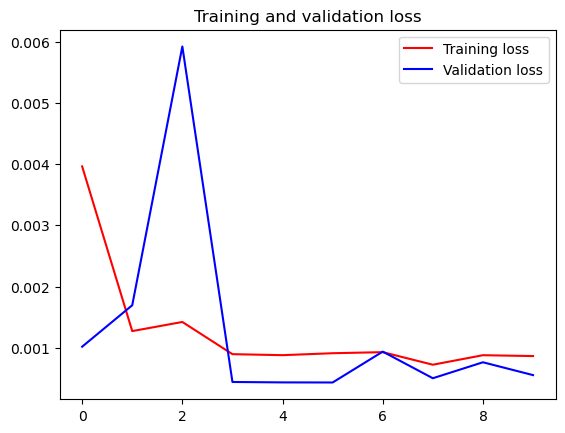

<Figure size 640x480 with 0 Axes>

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [13]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(x_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(y_test.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(y_test.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(y_test.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.961999
R2 Score: 0.961999
Max Error: 0.084276


In [14]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 [==============================] - 0s 14ms/step


9.350821955402116

/var/folders/l4/8b486cvj0kd783b5k2yvkvg80000gn/T/ipykernel_12920/634414014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


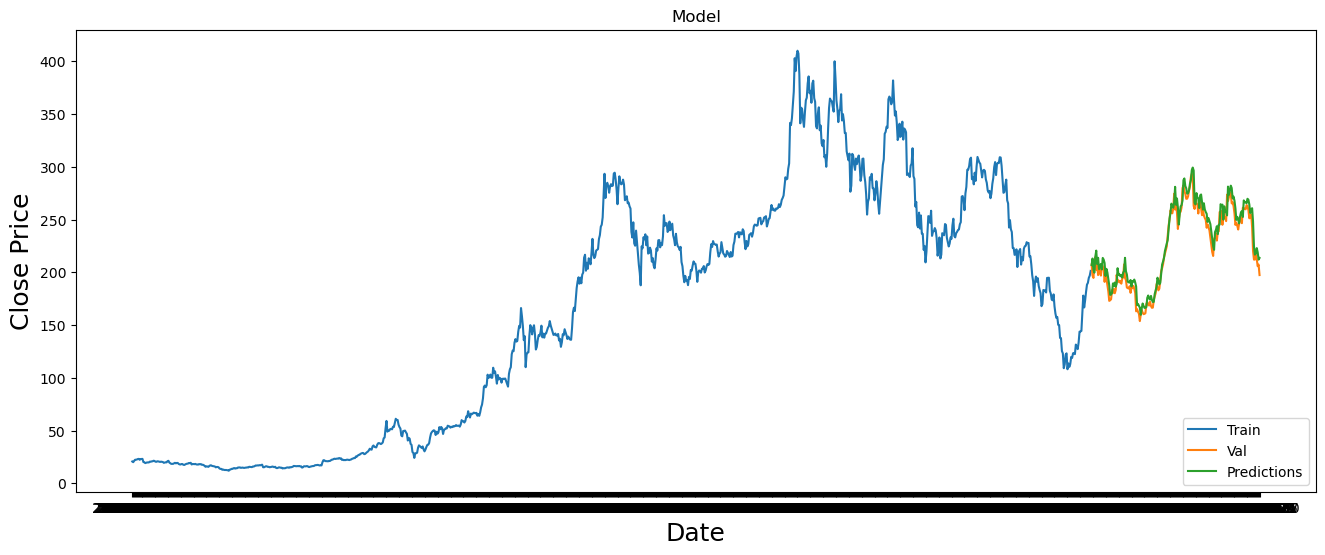

In [15]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [16]:
valid

,Close,Predictions
Date,,
2023-02-09,207.320007,206.815903
2023-02-10,196.889999,213.027466
2023-02-13,194.639999,202.366592
2023-02-14,209.250000,199.632599
2023-02-15,214.240005,214.840652
...,...,...
2023-10-24,216.520004,217.672943
2023-10-25,212.419998,222.916489
2023-10-26,205.759995,218.944290
